In [1]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
from functions import *
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


Bad key "text.kerning_factor" on line 4 in
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
df = pd.read_csv('train.csv')
df = df[~df.Age.isna()]
df = df[~df.Embarked.isna()]
y = df[['Survived']]
df = df.drop(columns = ['Survived'])

Key points
- Conditional Indipendence Assumption: There are no unobserved differences correlated to potential outcomes once we have controlled for certain observable characteristics
- Participation can be considered random among observations with the same characteristics
- Identification condition: observations with similar characteristics X present in both treatment and control groups. This requires 0 < P(T=1|X) < 1
- Selection on treatment (or not) should be solely based on observable characteristics (i.e. X). Assuming there is no selection bias from unobserved characteristics. It is not possible to prove the validity of this unconfoundedness assumption.
- There is a cost in not doing RCT (randomised controlled testing)
- Curse of dimensionality -> propensity score matching
- Prop. score: propability of participating in the treatment based on observable characteristics (i.e. X)

caliper: 25% of SD of logit(prop. score)

In [4]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [5]:
# Treatment effect: passenger has cabin (1) or not (0)
df['treatment'] = df.Cabin.apply(hasCabin)

In [6]:
# There is high correlation between treatment (i.e. hasCabin) and Class.
# This is desirable in this case as it plays the role of the systematic factor affecting the treatment.
# In a different context this could be a landing page on site that only specific visitors see.
pd.pivot_table(df[['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1,2,3
treatment,,,
0,158,15,10
1,26,158,345


In [7]:
# Keeping only specific variables
# We should account for all variables that affect the treatment variable (i.e. hasCabin)
df_data = df[['treatment','Sex','Age','SibSp','Parch','Embarked', 'Pclass', 'Fare']]

In [8]:
T = df_data.treatment
X = df_data.loc[:,df_data.columns !='treatment']

In [9]:
X_encoded = pd.get_dummies(X, columns = ['Sex','Embarked', 'Pclass'], \
                           prefix = {'Sex':'sex', 'Embarked' : 'embarked', 'Pclass' : 'class'}, drop_first=False)

In [10]:
# Design pipeline to build the treatment estimator
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X_encoded, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [11]:
predictions = pipe.predict_proba(X_encoded)

In [12]:
# Convert propability to logit. Based on 
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])

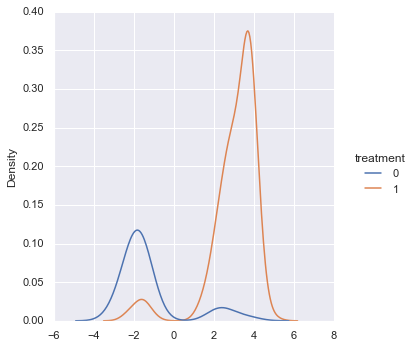

In [13]:
# Density distribution of propensity score (logic) broken down by treatment status
sns.displot(x = predictions_logit, hue = T , kind = 'kde')

In [14]:
# for i in range(2):
#    plt.hist(predictions_logit[T == i], density= True , alpha=0.3, label = 'Treat: {}'.format(pipe.classes_[i]), bins = 20)
# plt.legend()

There is good overlap only between -3 and -1 for logit propensity score. That area contains a lot more untreated samples versus the treated ones. This will give us a good pool of samples to perform the matching and obtain a more balanced view of the covariates.

In [15]:
common_support = (predictions_logit > -3) & (predictions_logit < -1)

In [16]:
df_data.loc[:,'propensity_score'] = predictions[:,1]
df_data.loc[:,'propensity_score_logit'] = predictions_logit
df_data.loc[:,'outcome'] = y.Survived

X_encoded.loc[:,'propensity_score'] = predictions[:,1]
X_encoded.loc[:,'propensity_score_logit'] = predictions_logit
X_encoded.loc[:,'outcome'] = y.Survived
X_encoded.loc[:,'treatment'] = df_data.treatment

/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/konos/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [17]:
X_encoded.head()

,Age,SibSp,Parch,Fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,class_1,class_2,class_3,propensity_score,propensity_score_logit,outcome,treatment
0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1,0.978844,3.834463,0,1
1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0,0.133245,-1.872566,1,0
2,26.0,0,0,7.9250,1,0,0,0,1,0,0,1,0.960018,3.178512,1,1
3,35.0,1,0,53.1000,1,0,0,0,1,1,0,0,0.104893,-2.144005,1,0
4,35.0,0,0,8.0500,0,1,0,0,1,0,0,1,0.980087,3.896294,0,1


Within the common support area, there are 25 treated samples. There are 152 untreated samples that we can use as a pool for the matching.

In [18]:
pd.pivot_table(df.iloc[common_support][['treatment','Pclass','PassengerId']], \
               values = 'PassengerId', index = 'treatment', columns = 'Pclass',\
               aggfunc= np.count_nonzero)

Pclass,1
treatment,
0,152
1,25


## Matching Implementation
Use Nearerst Neighbors to perform 1-to-1 matching. 

In [19]:
caliper = np.std(df_data.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X_encoded.loc[common_support].reset_index().rename(columns = {'index':'old_index'})

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0889



NearestNeighbors(n_neighbors=10, radius=0.08890268148266273)

In [20]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [21]:
def perfom_matching(row, indexes, df_data):
    current_index = int(row['index']) # Obtain value from index-named column, not the actual DF index.
    # import pdb;pdb.set_trace()
    for idx in indexes[current_index,:]:
        if (current_index != idx) and (row.treatment == 1) and (df_data.loc[idx].treatment == 0):
            return int(idx)

In [22]:
df_data['matched_element'] = df_data.reset_index().apply(perfom_matching, axis = 1, args = (indexes, df_data))

In [23]:
treated_with_match = ~df_data.matched_element.isna()
untreated_with_match = df_data.reset_index()['index'].isin(df_data.matched_element)

In [24]:
all_matched_elements = pd.DataFrame(data = {'a' : treated_with_match, 'b' :untreated_with_match}).any(axis = 1)

In [25]:
matched_data = df_data.loc[all_matched_elements]

In [26]:
matched_data.treatment.value_counts()

1    25
0    24
Name: treatment, dtype: int64

# Matching Review

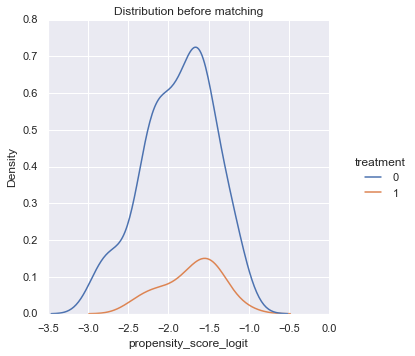

In [27]:
sns.displot(data = df_data, x = 'propensity_score_logit', hue = 'treatment', kind = 'kde').set(title='Distribution before matching')

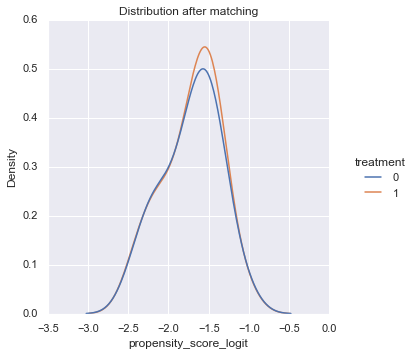

In [28]:
sns.displot(data = matched_data, x = 'propensity_score_logit', hue = 'treatment', kind = 'kde').set(title='Distribution after matching')

In [29]:
# sns.jointplot(data = df_data, x = 'propensity_score_logit', y = 'outcome', hue = 'treatment')

In [30]:
# sns.jointplot(data = tmp, x = 'propensity_score_logit', y = 'outcome', hue = 'treatment')

In [31]:
''' def cohenD (tmp, metricName):
    treated_metric = tmp[tmp.treatment == 1][metricName]
    untreated_metric = tmp[tmp.treatment == 0][metricName]
    
    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
    return d
    
'''

' def cohenD (tmp, metricName):\n    treated_metric = tmp[tmp.treatment == 1][metricName]\n    untreated_metric = tmp[tmp.treatment == 0][metricName]\n    \n    d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))\n    return d\n    \n'

In [32]:
data = []
cols = ['Age','SibSp','Parch','Fare','sex_female','sex_male','embarked_C','embarked_Q','embarked_S','class_1','class_2','class_3']
for cl in cols:
    data.append([cl,'before', cohenD(df_data,cl)])
    data.append([cl,'after', cohenD(matched_data,cl)])

/Users/konos/Documents/data-projects/propensity-scoring/functions.py:31: RuntimeWarning: invalid value encountered in double_scalars
  d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
/Users/konos/Documents/data-projects/propensity-scoring/functions.py:31: RuntimeWarning: invalid value encountered in double_scalars
  d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (untreated_metric.count()-1)*untreated_metric.std()**2) / (treated_metric.count() + untreated_metric.count()-2))
/Users/konos/Documents/data-projects/propensity-scoring/functions.py:31: RuntimeWarning: invalid value encountered in double_scalars
  d = ( treated_metric.mean() - untreated_metric.mean() ) / math.sqrt(((treated_metric.count()-1)*treated_metric.std()**2 + (un

In [33]:
res = pd.DataFrame(data, columns=['variable','matching','effect_size'])

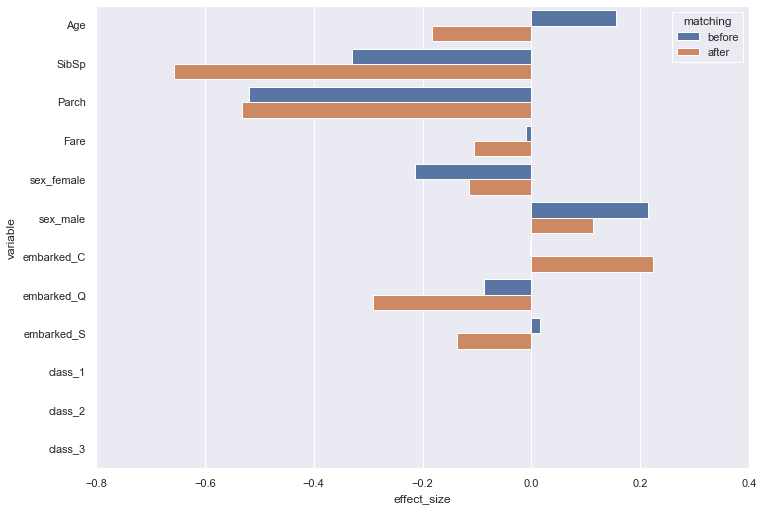

In [34]:
sns.barplot(data = res, y = 'variable', x = 'effect_size', hue = 'matching', orient='h')

# Average Treatement effect